In [ ]:
%%bash
if ls *.zip
then
    for z in *.zip
    do
        unzip "$z"
        rm "$z"
    done
    for c in *.csv
    do
        chmod +rwx "$c"
    done
    if ! test -d csvs
    then
        mkdir csvs
    fi
    mv *.csv csvs/
fi

In [ ]:
!ls csvs

In [39]:
import pandas as pd
import re
from glob import glob
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [ ]:
dfs = {}
for path in glob('csvs/*.csv'):
    df = pd.read_csv(path, skiprows=1, skipfooter=2, engine='python')
    pattern = re.compile(r'csvs/([^\.]*).*')
    match = pattern.search(path)
    dfs[match.group(1)] = df

In [ ]:
len(dfs)

In [ ]:
df = pd.concat(dfs.values())

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.to_csv('historical.csv')

In [ ]:
df.head(3)

In [ ]:
current = pd.read_csv('./csvs/primaryMarketNotes_browseNotes_1-RETAIL.csv')
current.head(3)

In [ ]:
current.shape

In [ ]:
## Check for uncommon features between current and historical.
comm = set(df.columns) & set(current.columns)
diff = set(df.columns) ^ set(current.columns)
diff_df = set(diff) & set(df.columns)
diff_curr = set(diff) & set(current.columns)
len(diff), len(diff_df), len(diff_curr)

In [ ]:
diff_df, diff_curr

In [ ]:
df['loan_status'].unique()
df['grade'].unique()

In [ ]:
## Grab only concluded loan_status
loan_status = df['loan_status'].isin(['Charged Off', 'Fully Paid'])
## Grab only grades A-D
grades = df['grade'].isin(['C', 'D', 'A', 'B'])

df_grade_loan = df.where(grades & loan_status).dropna(subset=['grade', 'loan_status'])

In [ ]:
df_grade_loan['loan_status'].unique(), df_grade_loan['grade'].unique()

In [ ]:
##grab only common columns between current and historical
comm.add('loan_status')
df_hist_curr = df_grade_loan[comm]
df_hist_curr.shape

In [ ]:
df_hist_curr['loan_status'].value_counts(normalize=True)

In [ ]:
df_hist_curr_sample, _ = tts(df_hist_curr,
                             test_size=.9,
                             stratify=df_hist_curr['loan_status']
                            )

In [ ]:
df_hist_curr.to_csv('historical_current_cleaned.csv')
df_hist_curr_sample.to_csv('historical_current_cleaned_sample.csv')

In [2]:
df_hist_curr = pd.read_csv('historical_current_cleaned.csv', engine='python')
df_hist_curr_sample = pd.read_csv('historical_current_cleaned_sample.csv', engine='python')

In [3]:
df_hist_curr_sample.describe(include='number')

,Unnamed: 0,mths_since_rcnt_il,sec_app_inq_last_6mths,annual_inc_joint,total_cu_tl,collections_12_mths_ex_med,all_util,inq_last_6mths,num_op_rev_tl,acc_open_past_24mths,open_act_il,annual_inc,mths_since_last_major_derog,chargeoff_within_12_mths,num_tl_30dpd,num_tl_op_past_12m,bc_open_to_buy,num_accts_ever_120_pd,pub_rec_bankruptcies,tot_hi_cred_lim,mths_since_recent_bc,mths_since_recent_bc_dlq,open_il_12m,sec_app_mort_acc,tot_coll_amt,dti,mo_sin_old_rev_tl_op,num_il_tl,revol_bal_joint,total_bal_il,num_rev_tl_bal_gt_0,member_id,mo_sin_old_il_acct,num_tl_120dpd_2m,max_bal_bc,bc_util,delinq_2yrs,total_bal_ex_mort,inq_fi,open_rv_24m,total_bc_limit,num_sats,loan_amnt,pub_rec,open_il_24m,id,sec_app_open_act_il,percent_bc_gt_75,dti_joint,url,sec_app_mths_since_last_major_derog,total_rev_hi_lim,sec_app_revol_util,installment,mths_since_last_delinq,mths_since_last_record,sec_app_chargeoff_within_12_mths,tot_cur_bal,open_acc,mo_sin_rcnt_rev_tl_op,avg_cur_bal,open_acc_6m,num_bc_sats,acc_now_delinq,funded_amnt,sec_app_num_rev_accts,num_tl_90g_dpd_24m,inq_last_12m,num_bc_tl,revol_bal,total_il_high_credit_limit,num_actv_bc_tl,delinq_amnt,open_rv_12m,mths_since_recent_revol_delinq,mo_sin_rcnt_tl,tax_liens,mths_since_recent_inq,sec_app_collections_12_mths_ex_med,sec_app_open_acc,total_acc,mort_acc,num_rev_accts,pct_tl_nvr_dlq,num_actv_rev_tl,il_util
count,128334.000000,54115.000000,2039.000000,2745.000000,55671.000000,128332.000000,55665.000000,128334.000000,122322.000000,124158.000000,55671.000000,1.283340e+05,33449.000000,128332.000000,122322.000000,122322.000000,122897.000000,122322.000000,128272.000000,1.223220e+05,122986.00000,30491.000000,55671.00000,2039.000000,122322.000000,128279.000000,122322.000000,122322.000000,2039.000000,55671.000000,122322.000000,0.0,118663.000000,117622.000000,55671.00000,122827.000000,128334.000000,1.241580e+05,55671.000000,55671.000000,124158.000000,123354.000000,128334.000000,128334.000000,55671.000000,0.0,2039.000000,122849.000000,2745.000000,0.0,689.000000,1.223220e+05,2009.000000,128334.000000,63296.000000,21477.000000,2039.000000,1.223220e+05,128334.000000,122322.000000,122317.000000,55671.000000,123354.000000,128334.000000,128334.000000,2039.000000,122322.000000,55671.000000,122322.000000,128334.000000,1.223220e+05,122322.000000,128334.000000,55671.000000,43142.000000,122322.000000,128334.000000,111401.000000,2039.000000,2039.000000,128334.000000,124158.000000,122322.000000,122309.000000,122322.000000,47913.000000
mean,111710.391377,20.195583,0.735655,119478.734047,1.572201,0.017042,57.240456,0.606488,8.255514,4.567092,2.773994,7.689539e+04,43.751263,0.008907,0.003164,2.093924,10838.973913,0.509630,0.132133,1.768118e+05,24.37301,39.595553,0.72862,1.729769,244.762790,18.047095,183.677139,8.497237,31647.852869,35282.023154,5.531033,NaN,126.238853,0.000782,5572.57459,58.616119,0.318575,4.931395e+04,1.034991,2.915540,22323.489538,11.615343,14036.521499,0.210381,1.667762,NaN,2.953409,43.417355,18.496262,NaN,38.471698,3.341865e+04,55.704181,425.970883,34.275863,70.834707,0.067190,1.422712e+05,11.570784,13.505330,13638.476009,0.997827,4.746867,0.004691,14030.340751,12.984306,0.088349,2.182537,8.115981,16134.382502,4.205291e+04,3.629879,15.939564,1.370444,35.739187,8.104830,0.050509,6.927909,0.085336,11.327612,24.900829,1.674367,14.598110,94.133843,5.582961,70.631854
std,97976.416919,25.185005,1.088912,62148.389983,2.778318,0.144396,21.053037,0.895854,4.557045,3.123497,2.986499,7.533379e+04,21.240044,0.104702,0.060233,1.791623,15880.098982,1.342455,0.373368,1.847055e+05,31.14471,22.639579,0.95349,2.000013,3262.703355,11.207255,95.762683,7.339195,26348.083324,42197.105758,3.166696,NaN,52.215377,0.028854,5353.41225,28.310164,0.886995,4.733180e+04,1.519006,2.636177,22060.505728,5.500467,8574.864134,0.570257,1.622784,NaN,3.222268,35.825833,7.492806,NaN,23.812119,3.337809e+04,26.268304,256.555971,21.867830,26.583462,0.605744,1.581475e+05,5.487244,16.610451,16636.154013,1.167372,2.963213,0.072962,8572.915214,8.19384

In [4]:
df_hist_curr_sample.describe(exclude='number')

,home_ownership,addr_state,initial_list_status,earliest_cr_line,emp_length,desc,title,grade,purpose,revol_util,emp_title,sub_grade,sec_app_earliest_cr_line,int_rate,loan_status,zip_code,application_type,term
count,128334,128334,128334,128334,120628,11252,126680,128334,128334,128265,119915,128334,2039,128334,128334,128334,128334,128334
unique,6,51,2,659,11,11231,7865,4,14,1114,54092,20,398,396,2,884,2,2
top,MORTGAGE,CA,w,Sep-2003,10+ years,,Debt consolidation,B,debt_consolidation,0%,Teacher,C1,Aug-2006,10.99%,Fully Paid,945xx,Individual,36 months
freq,64004,18692,77690,898,41981,11,62886,41625,73546,681,2089,9053,26,3819,105857,1437,125589,103161


In [9]:
null_col = df_hist_curr_sample.isnull().sum().sort_values(ascending=False)[:73].keys().to_list()
per_col = ['int_rate', 'revol_util']
job_buckets = ['teacher', 'manager', 'owner']
drop_me = ['id', 'member_id', 'title', 'grade']
len_me = ['desc']

def wrangle(df):
    df = df.copy()
    ## Remove Nulls
    for col in null_col:
        df[f'{col}_missing'] = df[col].isnull()
    for col in per_col:
        df[col] = df[col].astype(str).str.strip('%').astype(float)
    for col in len_me:
        df[col] = df[col].astype(str).str.len()
    df['emp_title'] = df['emp_title'].str.lower()
    for job in job_buckets:
        df[f'emp_title_{job}'] = df['emp_title'].str.contains(job, na=False)
    df = df.drop(columns=drop_me)
    def wrangle_sub_grade(x):
        first_digit = ord(x[0]) - 64
        second_digit = int(x[1])
        return first_digit + second_digit/10
    df['sub_grade'] = df['sub_grade'].apply(wrangle_sub_grade)
    return df

In [11]:
def x_y_split(df, target):
    y = df[target]
    x = df.drop(columns=target)
    return x, y

In [27]:
x, y = x_y_split(wrangle(df_hist_curr_sample), 'loan_status')
x_trainval, x_test, y_trainval, y_test = tts(x,
                                             y,
                                             test_size=.2,
                                            )
x_train, x_val, y_train, y_val = tts(x_trainval,
                                     y_trainval,
                                     test_size= .25
                                    )
x_train.shape, x_val.shape, x_test.shape, x.shape

((77000, 175), (25667, 175), (25667, 175), (128334, 175))

In [30]:
prep = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

x_train_prep = prep.fit_transform(x_train)
x_val_prep = prep.transform(x_val)

eval_set = [(x_train_prep, y_train), 
            (x_val_prep, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(x_train_prep, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.671314	validation_1-auc:0.653234
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.679946	validation_1-auc:0.675039
[2]	validation_0-auc:0.681559	validation_1-auc:0.677633
[3]	validation_0-auc:0.683363	validation_1-auc:0.67838
[4]	validation_0-auc:0.68464	validation_1-auc:0.679521
[5]	validation_0-auc:0.685515	validation_1-auc:0.679885
[6]	validation_0-auc:0.685896	validation_1-auc:0.681022
[7]	validation_0-auc:0.686631	validation_1-auc:0.682536
[8]	validation_0-auc:0.687804	validation_1-auc:0.683496
[9]	validation_0-auc:0.688068	validation_1-auc:0.683983
[10]	validation_0-auc:0.688448	validation_1-auc:0.684695
[11]	validation_0-auc:0.68894	validation_1-auc:0.685063
[12]	validation_0-auc:0.689571	validation_1-auc:0.685381
[13]	validation_0-auc:0.68997	validation_1-auc:0.685942
[14]	validation_0-auc:0.690244	validation_1-auc:0.68617
[15

[141]	validation_0-auc:0.732424	validation_1-auc:0.704241
[142]	validation_0-auc:0.732489	validation_1-auc:0.704226
[143]	validation_0-auc:0.73261	validation_1-auc:0.704208
[144]	validation_0-auc:0.732771	validation_1-auc:0.704267
[145]	validation_0-auc:0.732954	validation_1-auc:0.704206
[146]	validation_0-auc:0.733127	validation_1-auc:0.704231
[147]	validation_0-auc:0.733245	validation_1-auc:0.704216
[148]	validation_0-auc:0.733355	validation_1-auc:0.70425
[149]	validation_0-auc:0.733455	validation_1-auc:0.704177
[150]	validation_0-auc:0.733597	validation_1-auc:0.704196
[151]	validation_0-auc:0.733708	validation_1-auc:0.704195
[152]	validation_0-auc:0.733894	validation_1-auc:0.704226
[153]	validation_0-auc:0.734036	validation_1-auc:0.704281
[154]	validation_0-auc:0.734155	validation_1-auc:0.704329
[155]	validation_0-auc:0.734284	validation_1-auc:0.704368
[156]	validation_0-auc:0.734484	validation_1-auc:0.704456
[157]	validation_0-auc:0.734707	validation_1-auc:0.704455
[158]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [32]:
!pip install mlxtend

    100% |████████████████████████████████| 1.3MB 10.3MB/s ta 0:00:01


              precision    recall  f1-score   support

           0       0.33      0.60      0.43        45
           1       0.85      0.65      0.73       155

   micro avg       0.64      0.64      0.64       200
   macro avg       0.59      0.62      0.58       200
weighted avg       0.73      0.64      0.66       200



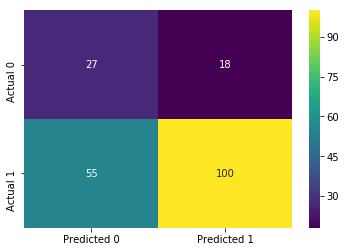

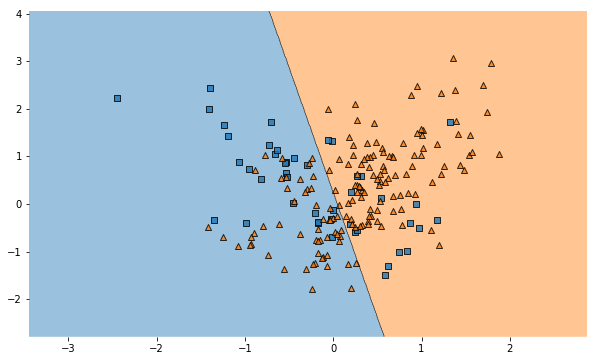

In [48]:
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')


#1. Generate data

# Try re-running the cell with different values for these parameters
n_samples = 1000
w1 = .2
w2 = 1 - w1
weights = (w1, w2)
class_sep = 0.3

x, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, n_classes=2, 
                           n_clusters_per_class=1, weights=weights, 
                           class_sep=class_sep, random_state=0)


# 2. Split data

# Uses our custom train_validation_test_split function
x_trainval, x_test, y_trainval, y_test = tts(x,
                                             y,
                                             test_size=.2,
                                            )
x_train, x_val, y_train, y_val = tts(x_trainval,
                                     y_trainval,
                                     test_size= .25
                                    )


# 3. Fit model

# Try re-running the cell with different values for this parameter
class_weight = 'balanced'

model = LogisticRegression(solver='lbfgs', class_weight=class_weight)
model.fit(x_train, y_train)


# 4. Evaluate model

y_pred = model.predict(x_val)
print(classification_report(y_val, y_pred))
plot_confusion_matrix(y_val, y_pred)

# 5. Visualize decision regions

plt.figure(figsize=(10, 6))
plot_decision_regions(x_val, y_val, model, legend=0);